Can we use the velocity of the binary orbit to move the m dwarf lya out of the airglow?

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import astropy.io.fits as fits
import os
import glob
from astropy.table import Table
from astropy.io import ascii
import astropy.units as u
import astropy.constants as const
from astropy.convolution import convolve, Box1DKernel
import scipy.interpolate as interpolate


#matplotlib set up
%matplotlib inline
from matplotlib import rcParams
rcParams["figure.figsize"] = (14, 5)
rcParams["font.size"] = 20

In [4]:
path = '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/'
x1ds = glob.glob(path+'/*/*x1d.fits')
x1ds

['/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O4MU01010/o4mu01010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O4MU01020/o4mu01020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O4MU02010/o4mu02010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O4MUA1010/o4mua1010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O4MUA2010/o4mua2010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O4MUA2020/o4mua2020_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O5DMA1010/o5dma1010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O5DMA2010/o5dma2010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/O5DMA3010/o5dma3010_x1d.fits',
 '/media/david/2tb_ext_hd/hddata/v471tau/MAST_

(0.0, 3e-12)

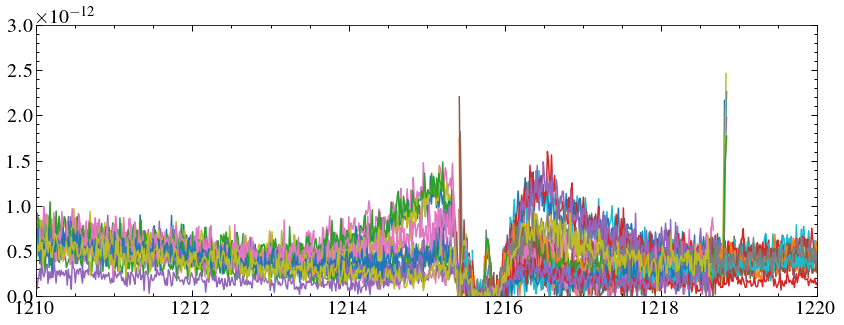

In [19]:
for x in x1ds:
    data = fits.getdata(x, 1)
    for dt in data:
        plt.plot(dt['WAVELENGTH'], dt['FLUX'])
plt.xlim(1210, 1220)
plt.ylim(0, 3e-12)

In [6]:
# import stisblazefix
# stisblazefix.fluxfix(x1ds, pdfname='blazefix')

In [7]:
"""x1fs = glob.glob(path+'*x1f.fits')
for x in x1fs:
    data = fits.getdata(x, 1)
    for dt in data:
        plt.plot(dt['WAVELENGTH'], dt['FLUX'])
#plt.xlim(1210, 1220)
plt.ylim(0, 3e-12)"""

"x1fs = glob.glob(path+'*x1f.fits')\nfor x in x1fs:\n    data = fits.getdata(x, 1)\n    for dt in data:\n        plt.plot(dt['WAVELENGTH'], dt['FLUX'])\n#plt.xlim(1210, 1220)\nplt.ylim(0, 3e-12)"

In [8]:
def spectra_adder(f_array, e_array):
    """
    Returns a variance-weighted coadd with standard error of the weighted mean (variance weights, scale corrected).
    f_array and e_arrays are collections of flux and error arrays, which should have the same lenth and wavelength scale
    """
    weights = 1 / (e_array**2)
    flux = np.average(f_array, axis =0, weights = weights)
    var = 1 / np.sum(weights, axis=0)
    rcs = np.sum((((flux - f_array)**2) * weights), axis=0) / (len(f_array)-1) #reduced chi-squared
    error = (var * rcs)**0.5
    #var1 = 
    return flux, var**0.5

def echelle_coadd(wavelength, flux, err, nclip =5):
    """
    combines echelle orders into one spectrum, stiching them together at the overlap 
    """
    #slice dodgy ends off orders (usually 5-10 for stis el40m)
    wavelength = wavelength[:, nclip:-(nclip+1)]
    flux = flux[:, nclip:-(nclip+1)]
    err = err[:, nclip:-(nclip+1)]
    
    #new arrays to put the output in
    w_full = np.array([], dtype=float)
    f_full = np.array([], dtype=float)
    e_full = np.array([], dtype=float)   

    shape = np.shape(flux)
    order = 0
    while order < (shape[0]):
        
        #first add the part that does not overlap ajacent orders to the final spectrum
        if order == 0: #first and last orders do not overlap at both ends
            overmask = (wavelength[order] > wavelength[order + 1][-1])
        elif order == shape[0]-1:
            overmask = (wavelength[order] < wavelength[order - 1][1])
        else:
            overmask = (wavelength[order] > wavelength[order + 1][-1]) & (wavelength[order] < wavelength[order - 1][1])
        w_full = np.concatenate((w_full, wavelength[order][overmask]))
        f_full = np.concatenate((f_full, flux[order][overmask]))
        e_full = np.concatenate((e_full, err[order][overmask]))
  
        if order != shape[0]-1:
            
            #interpolate each order onto the one beneath it, with larger wavelength bins. Code adapted from stisblazefix
            f = interpolate.interp1d(wavelength[order + 1], flux[order + 1], fill_value='extrapolate')
            g = interpolate.interp1d(wavelength[order + 1], err[order + 1], fill_value='extrapolate')
            overlap = np.where(wavelength[order] <= wavelength[order + 1][-1])
            f0 = flux[order][overlap]
            f1 = f(wavelength[order][overlap])
            g0 = err[order][overlap]
            g1 = g(wavelength[order][overlap])
       
             
            #combine flux and error at overlap and add to final spectrum
            w_av = wavelength[order][overlap]
            f_av, e_av = spectra_adder(np.array([f0,f1]),np.array([g0,g1]))
            w_full = np.concatenate((w_full, w_av))
            f_full = np.concatenate((f_full, f_av))
            e_full = np.concatenate((e_full, e_av))
        order += 1
    
    #stis orders are saved in reverse order, so combined spectra are sorted by the wavelength array
    arr1inds = w_full.argsort()
    sorted_w = w_full[arr1inds]
    sorted_f = f_full[arr1inds]
    sorted_e = e_full[arr1inds]
 
    
    return sorted_w, sorted_f, sorted_e

In [9]:
"""for x in x1fs:
    hdul = fits.open(x)
    header=hdul[0].header
    data = hdul[1].data
    w, f, e = echelle_coadd(data['WAVELENGTH'], data['FLUX'], data['ERROR'])
    mask = (w > 1160)
    savepath = '{}stitched_e140m/{}_stitched.ecsv'.format(path, header['ROOTNAME'])
    savdat = Table([w,f,e], names=['WAVELENGTH', 'FLUX', 'ERROR'], meta=dict(tstart=header['TEXPSTRT'], tend=header['TEXPEND']))
    ascii.write(savdat, savepath, format='ecsv', overwrite=True)
    plt.plot(w[mask], f[mask])
    hdul.close()
    plt.show()"""

"for x in x1fs:\n    hdul = fits.open(x)\n    header=hdul[0].header\n    data = hdul[1].data\n    w, f, e = echelle_coadd(data['WAVELENGTH'], data['FLUX'], data['ERROR'])\n    mask = (w > 1160)\n    savepath = '{}stitched_e140m/{}_stitched.ecsv'.format(path, header['ROOTNAME'])\n    savdat = Table([w,f,e], names=['WAVELENGTH', 'FLUX', 'ERROR'], meta=dict(tstart=header['TEXPSTRT'], tend=header['TEXPEND']))\n    ascii.write(savdat, savepath, format='ecsv', overwrite=True)\n    plt.plot(w[mask], f[mask])\n    hdul.close()\n    plt.show()"

In [10]:
# hdul = fits.open(x)
# hdul[0].header

Get a Muscles spectrum to compare? 

In [11]:
lya = fits.getdata('hlsp_muscles_model_lya-reconstruction_v-eps-eri_na_v22_component-spec.fits',1)

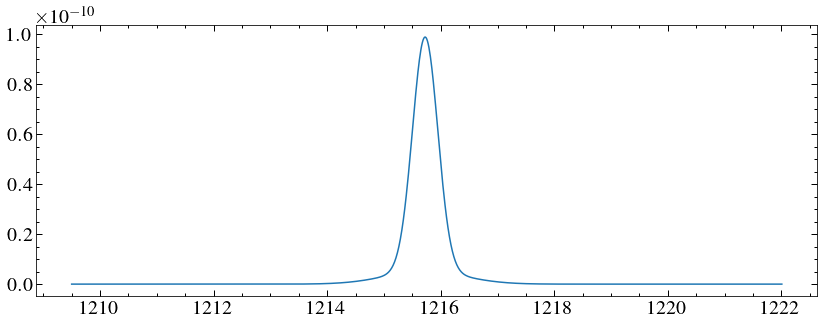

In [12]:
plt.plot(lya['WAVELENGTH'], lya['FLUX'])

In [13]:
de = 3.212
dv = 1/(20.95688223826358e-3)
scale = (de/dv)**2
print(scale)

0.004531108056261396


In [14]:
specs = glob.glob('{}stitched_e140m/*_stitched.ecsv'.format(path))
print(specs)
len(specs)

[]


0

In [15]:
tmids = []
for spec in specs:
    data=Table.read(spec)
    tmid = (data.meta['tstart']+data.meta['tend'])/2
    tmids.append(tmid)

Get binary period from https://ui.adsabs.harvard.edu/abs/2012ApJ...751...66S/abstract. Yay they have phased them up for me!

In [16]:
roots = np.array(['o4mu02010','o4mua2010','o4mua2020','o4mu01010','o4mu01020','o4mua1010','o5dma1010',
         'o5dma4010','o5dma2010','o5dma3010','o6jc01010','o6jc01020','o6jc01030','o6jc01040'])
phases = np.array([0.93,0.06,0.17,0.69,0.8,0.94,0.23,0.74,0.27,0.76,0.79,0.9,0.05,0.15])

args = np.argsort(phases)
roots= roots[args]
phases = phases[args]

In [17]:
smooth=5
for root, phase in zip(roots, phases):
    data = Table.read('{}stitched_e140m/{}_stitched.ecsv'.format(path, root))
    print(phase)
    w, f, e = np.array(data['WAVELENGTH']), np.array(data['FLUX']), np.array(data['ERROR'])
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    mask = (w > 1190) & (w < 1240)
    plt.plot(w[mask], f[mask])
    plt.ylim(-0.1e-12, 1.49e-12)
    plt.show()

FileNotFoundError: [Errno 2] No such file or directory: '/media/david/2tb_ext_hd/hddata/v471tau/MAST_2022-03-04T22_42_29.108Z/HST/stitched_e140m/o6jc01030_stitched.ecsv'

In [ ]:
from matplotlib.animation import FuncAnimation
#smooth=50




fig, ax = plt.subplots(figsize=(7,5))
fig.set_tight_layout(True)

#ax[0].plot(t, f_lc)
#ax[0].set_xlabel('Time (s)')
#ax[0].set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$)')
#ax[0].set_ylim(0.4, 1.2)
ax.set_xlim(1205.1, 1224.9)
ax.set_ylim(-0.1e-12, 1.49e-12)
# ax.set_yscale('log')

#line, = ax[0].plot([0,0], [-0.1e-12,1.3e-12], 'C1--', linewidth=2)
ax.set_ylabel('Flux (erg s$^{-1}$ cm$^{-2}$ \AA$^{-1}$)')
ax.set_xlabel('Wavelength (\AA)')
#ax.axvline(1393.775, ls='--', c='C1', alpha=0.5)
#ax.axvline(1402.770, ls='--', c='C1', alpha=0.5)
# [ax.axvline(line, ls='--', c='C1', alpha=0.5) for line in [1206.499 ,1238.821, 1242.804]]
#ax.fill_between([1215.392, 1215.948],0, 1, facecolor = 'k')
ax.axvline(1215.67, ls='--', c='C1', alpha=0.5)
#ext = hdul[1::][0]
#dt = ext.data[0]
#w, f = dt['WAVELENGTH'], dt['FLUX']
w, f, e = np.array([], dtype=float), np.array([], dtype=float), np.array([], dtype=float)
#w, f, e  = np.loadtxt(csv_files[0], unpack=True, delimiter=',')
line1, = ax.plot(w,f)
an = ax.annotate('', (0.95, 0.95), xycoords='axes fraction' , ha='right', va='top')
#std = np.max(modf)/200 #peak sn = 40 for one orbit 
# ax.fill_between([1215.392, 1215.948],0, 1, facecolor = '0.5', zorder=100)#, alpha=0.5)

def update(i):
    data = Table.read('{}stitched_e140m/{}_stitched.ecsv'.format(path, roots[i]))
#     phase = phases[i]
    w, f, e = np.array(data['WAVELENGTH']), np.array(data['FLUX']), np.array(data['ERROR'])
    f = convolve(f,Box1DKernel(smooth))
    e = convolve(e,Box1DKernel(smooth))/(smooth**0.5)
    mask = (w > 1205) & (w < 1225)
    w, f = w[mask], f[mask] 
    
    line1.set_xdata(w)
    line1.set_ydata(f)
    an.set_text('Phase = {:.2f}'.format(phases[i]))
    
   ## if ti > t0+2:
     #   t0 = ti
      #  obs =
   # an.set_text('Ob {0}'.format(obs))
 #   print(ti)
    return ax, line1, an

#ax.legend()
anim = FuncAnimation(fig, update, frames=np.arange(len(roots)), interval=200)
anim.save('plots/v471_tau_basic.gif', dpi=150, writer='imagemagick')
plt.show()

